In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from mpl_toolkits.basemap import Basemap
import numpy as np

In [3]:
xyz = pd.read_table("06_tx_1965-2023_jrk.xyz", delim_whitespace=True)

/var/folders/g4/8z1prdqs5l3dj5xzv765t_sc0000gn/T/ipykernel_1824/152992696.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz = pd.read_table("06_tx_1965-2023_jrk.xyz", delim_whitespace=True)


In [4]:
xyz

,X,Y,Z,T,loc
0,109682.41,558181.19,3.77,5-8-1965,900
1,109677.53,558180.09,3.63,5-8-1965,900
2,109672.65,558179.00,3.55,5-8-1965,900
3,109667.77,558177.91,3.41,5-8-1965,900
4,109662.89,558176.82,3.16,5-8-1965,900
...,...,...,...,...,...
1380678,117558.08,579018.26,-1.44,3-4-2023,3081
1380679,117551.46,579025.77,-1.70,3-4-2023,3081
1380680,117544.85,579033.27,-1.88,3-4-2023,3081
1380681,117538.24,579040.77,-2.14,3-4-2023,3081


In [5]:
xyz["year"] = xyz["T"].str[-4:].astype(int)

In [12]:
def plot_all_points(): 
    plt.figure();
    plt.plot(xyz["X"], xyz["Y"]);
    plt.show();

## Part 1: Plotting the coastline of Texel

In [10]:
def coastline(baseline, steps): 

    years = [year for year in xyz["year"].unique()]
    
    for year in years: 
        concat_rows = []
        if year == baseline: 
            data_year = xyz[xyz["year"] == year]
            locations = [location for location in data_year["loc"].unique()]
            for location in locations:  
                data_loc = data_year[data_year["loc"] == location]
                index_highest = data_loc['Z'].idxmax()
                concat_rows.append(data_loc.loc[index_highest, :].copy())
    
            baseline += steps  
            data_highest = pd.DataFrame(concat_rows)
            
            # Step 1: Convert RD (X, Y) to Latitude/Longitude
            # Define the transformer from RD (EPSG:28992) to WGS84 (EPSG:4326)
            transformer = Transformer.from_crs("EPSG:28992", "EPSG:4326")
            
            # Step 2: Apply the transformation to all X and Y coordinates in the DataFrame
            latlon_coords = data_highest.apply(lambda row: transformer.transform(row["X"], row["Y"]), axis=1)
            data_highest["Latitude"], data_highest["Longitude"] = zip(*latlon_coords)
            
            # Step 3: Map scatter points with basemap of Texel
            map = Basemap(projection='merc', llcrnrlon=4.65, llcrnrlat=52.95, urcrnrlon=4.9, urcrnrlat=53.2, resolution='h')
            map.drawcoastlines()
            # map.drawcountries()
            # map.drawmapboundary(fill_color='aqua')
            map.fillcontinents(color='lightgray')
            
            x, y = map(data_highest["Longitude"].values, data_highest["Latitude"].values)
            map.scatter(x, y, c=data_highest["Z"], s=25, cmap='viridis', edgecolors='k', zorder=5)
            plt.colorbar(label="Z (Altitude)")
            plt.title(f'Coastline Texel in {year}')
            plt.show()

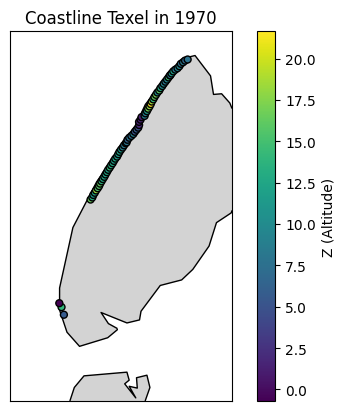

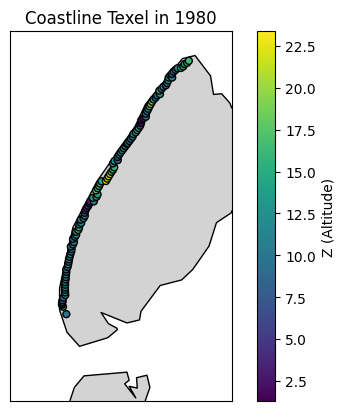

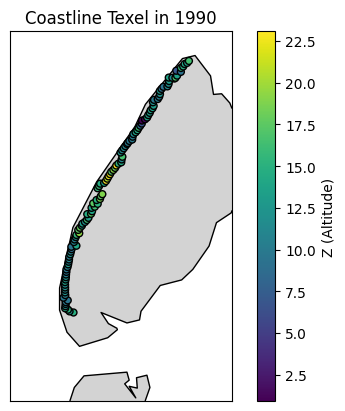

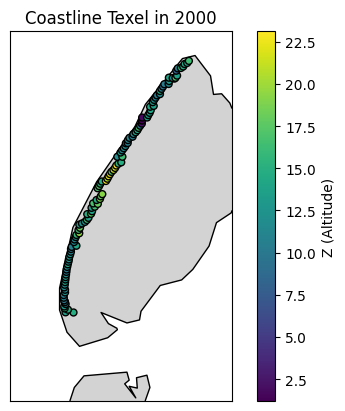

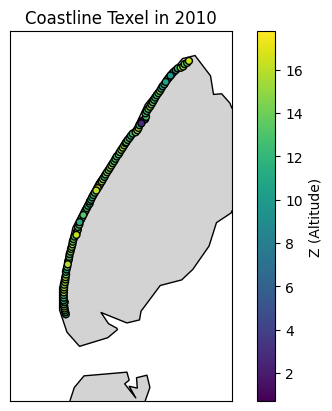

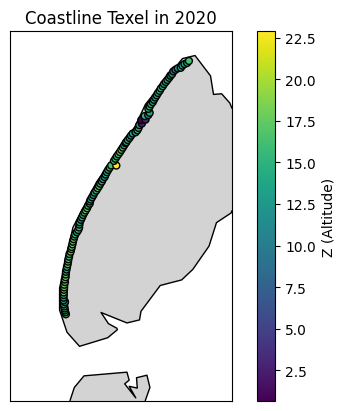

In [11]:
coastline(1970, 10)

## Part 2: Sediment budget over time

In [13]:
xyz

,X,Y,Z,T,loc,year
0,109682.41,558181.19,3.77,5-8-1965,900,1965
1,109677.53,558180.09,3.63,5-8-1965,900,1965
2,109672.65,558179.00,3.55,5-8-1965,900,1965
3,109667.77,558177.91,3.41,5-8-1965,900,1965
4,109662.89,558176.82,3.16,5-8-1965,900,1965
...,...,...,...,...,...,...
1380678,117558.08,579018.26,-1.44,3-4-2023,3081,2023
1380679,117551.46,579025.77,-1.70,3-4-2023,3081,2023
1380680,117544.85,579033.27,-1.88,3-4-2023,3081,2023
1380681,117538.24,579040.77,-2.14,3-4-2023,3081,2023


In [132]:
def sediment_budget(data, threshold): 
    """
    Computes sediment budget per year
    """
    volume_development = pd.DataFrame(columns=['Year', 'Volume of dunes'])
    years = [year for year in data["year"].unique()]
    for year in years: 
        data_year = data[data["year"] == year]
        locations = [location for location in data_year["loc"].unique()]
        volume_dunes = 0
        for location in locations:  
            data_loc = data_year[data_year["loc"] == location]
            data_rsp = data_loc[data_loc["X"] <= 109870]
            data_positive = data_rsp[data_rsp["Z"] > threshold]
            volume_location = 0
            for i in range(1, len(data_positive)):
                # Calculate the area of the base formed by the X and Y coordinates
                base_area = np.abs((data_positive['X'].iloc[i] - data_positive['X'].iloc[i-1]) * 
                                   (data_positive['Y'].iloc[i] - data_positive['Y'].iloc[i-1]))
                
                # Average height between the two points
                avg_height = (data_positive['Z'].iloc[i] + data_positive['Z'].iloc[i-1]) / 2
                
                # Volume contribution from this segment
                volume_location += base_area * avg_height

            volume_dunes += volume_location
            
        # Create a temporary DataFrame for the new row
        new_row_df = pd.DataFrame({'Year': [year], 'Volume of dunes': [volume_dunes]})
        volume_development = pd.concat([volume_development, new_row_df], ignore_index=True)
        
    return volume_development

In [134]:
sediment_budget = sediment_budget(data = xyz, threshold = 2)

/var/folders/g4/8z1prdqs5l3dj5xzv765t_sc0000gn/T/ipykernel_1824/150722988.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  volume_development = pd.concat([volume_development, new_row_df], ignore_index=True)


In [136]:
sediment_budget

,Year,Volume of dunes
0,1965,1757.916125
1,1966,2129.186693
2,1967,1595.358934
3,1968,2232.354601
4,1969,1423.923399
5,1970,1335.377945
6,1971,1309.865626
7,1972,0.000000
8,1973,1596.334332
9,1974,1470.000480


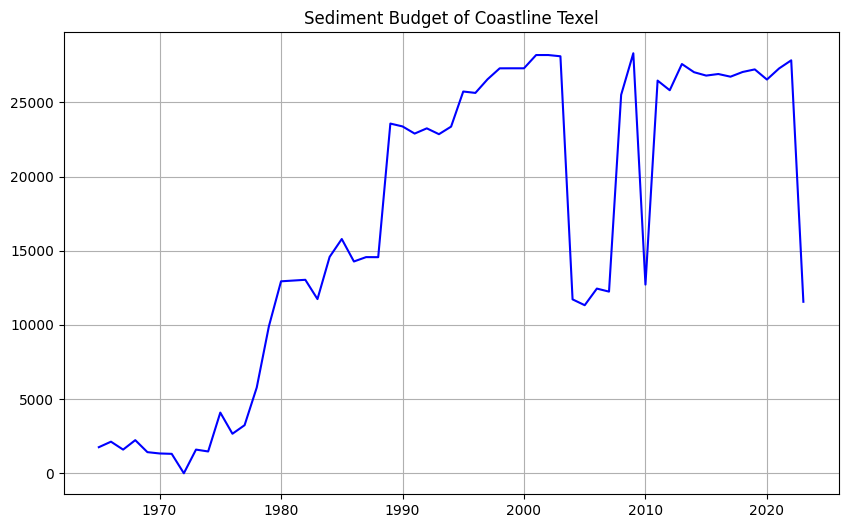

In [135]:
plt.figure(figsize=(10,6))
plt.plot(sediment_budget["Year"], sediment_budget["Volume of dunes"], color='b')
plt.grid()
plt.title(f"Sediment Budget of Coastline Texel")
plt.show()

In [ ]:
# Plotting the function
# plt.figure(figsize=(10, 6))
# plt.plot(data_loc["X"], data_loc["Z"], color='b')
# plt.fill_between(data_positive["X"], data_positive["Z"], color='lightblue', alpha=0.5)
# plt.grid()
# plt.title(f"The dune volume above {above_NAP}m NAP for location {location} in {year}")
# plt.show()
# plt.clf()